# Code for Replicating CoDoC Experiment Results

This file is designed for the replication of the results of the experiments presented in the paper: _Enhancing the reliability and accuracy of AI-enabled diagnosis via complementarity-driven deferral to clinicians (CoDoC)_, by Dvijotham et al., 2023, published in _Nature Medicine_.

A detailed set of instructions for using this file to replicate the experiments is provided in the supplementary material for the manuscript. In addition, this file also includes some instructive commentary, as well as guidance with respect to the specifics of the implementation. If you encounter any difficulty with the code and instructions in this file, feel free to contact the authors of the paper.

## Obtaining and Utilizing Data

Please see the `README` file in this repository for information regarding accessing the datasets featured in the paper.

This notebook describes how to utilize our code once you obtain the data, or using your own data. See below for instructions regarding using this repository with your own dataset.

The dataset to be used must consist of three files `tune.csv`, `val.csv`, and `test.csv`, containing the tune, validation, and test splits. All three files must include the columns for ground truth (`y_true`), ML model predictions (`y_model`), and clinical workflow opinions (`reader_score`).

Based on the experiment you are attempting to replicate, the three files are placed under the following subfolders:

- `data/uk_mammo/single_reader/` for experiments with UK Mammography Dataset and single reader.
- `data/uk_mammo/arbitration/` for experiments with UK Mammography Dataset and arbitration.
- `data/us_mammo/` for experiments with US Mammography Dataset.

For any custom data, prepare the splits as described above and place them under the directory `data/[experiment_name]`, with an `experiment_name` of your own choosing.

## Training CoDoC with A Single Hyperparameter Setting

### Setting experiment name and target metric, loading data and hyperparameters

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import jax
import codoc

This section can be used to reproduce specific experiment results from the main paper. With the provided `experiment_name`, the data files and the hyperparameters will be automatically loaded based on the experiment setting and target metric you specified. For replicating results, please make sure you select `experiment_name` from among the provided options below in the long comment at the start of the cell. In cases where you are running this notebook with your own data, make sure you have stored the data under `data/[experiment_name]` as described above, according to the `experiment_name` you chose to use.

In the cell below, `load_data` loads tune, validation, and test splits for your data as three separate `pandas.DataFrame` objects. Based on the `experiment_name` you provided, the code accesses the folder `data/[experiment_name]` and loads the files `tune.csv`, `val.csv`, `test.csv` as the respective data splits.

Following this, `load_hyperparameters` function accesses the file `hyperparameters.json` and loads it as a `dict` object. This dictionary includes specific model hyperparameters to replicate the results in the main paper.

Specify `target_metric` based on which model result you are trying to obtain: Models in the main paper have been chosen according to either to maximize sensitivity (`sens`) or specificity (`spec`).

The last lines of the cell assign to the variable `hp` the desired model's hyperparameters for easy access. If you get a `KeyError` exception, that means you are attempting to access an experiment that is not present in the main paper or is not available through this repository. If you are using a custom dataset, it is normal to see this exception, and you are free to provide hyperparameters as desired (or select them using our model selection methodology, see next section).

In [2]:
"""Experiment Name Choices

Featured datasets:
- "uk_mammo_single", "uk_mammo_arbitration" for UK Mammography Dataset with
      either single reader or arbitration respectively.
- "us_mammo" for US Mammography Dataset.

For own datasets, pass the experiment name you have assigned once you store the
data under `data/[experiment_name]`.
"""
experiment_name = "uk_mammo_single"
df_tune, df_val, df_test = codoc.load_data(experiment_name)
all_hp = codoc.load_hyperparameters()

# Target metric: "sens" for sensitivity, "spec" for specificity.
target_metric = "spec"

try:
  hp = all_hp[experiment_name + "_" + target_metric]
except KeyError:
  hp = {}
  print(
      "The experiment + target_metric combination"
      f" {experiment_name + '_' + target_metric} you requested cannot be found!"
  )

### Running the experiment with loaded hyperparameters and plotting the results

In the following cell, the function `estimate_model` takes the tune and validation splits we have loaded above, as well as model hyperparameters to estimate a CoDoC model. If you are using a custom dataset, feel free to provide custom hyperparameters by changing the inputs to `estimate_model`. This function returns a `dict` object that includes the estimated model's parameters, namely thresholds within which the decisions will be deferred to a clinician. This dictionary will also include sensitivity and specificity estimates in the tune and validation splits, as well as auxiliary statistics such as the percent of cases deferred to a clinician in tune and validation splits.

Following the estimation of the model, `evaluate_codoc_model` uses the model parameters and the test data to estimate CoDoC model's sensitivity and specificity on test set. Similarly, `evaluate_baseline_reader` and `evaluate_baseline_model` computes these estimates for the clinician and AI model respectively.

To visualize the CoDoC decision procedure, `plot_advantage_z` takes the model's output and plots $Advantage(z)$ for $z \in [0,1]$, the operating point $\theta$, and colors this plot according to $Defer(z)$.

CoDoC sensitivity on test set: 0.6641975308641975
CoDoC specificity on test set: 0.9545671927307509
Number of cases in test set is 25497
Number of positive cases in test set is 405
Clinical workflow sensitivity on test set: 0.6271604938271605
Clinical workflow specificity on test set: 0.9281444285031085
Predictive AI sensitivity on test set: 0.6493827160493827
Predictive AI specificity on test set: 0.9393432169615814


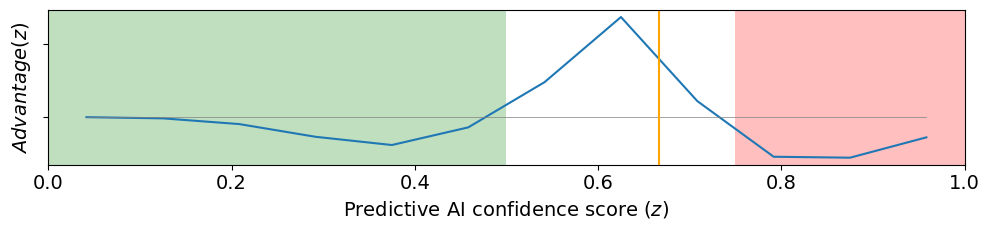

In [3]:
# Obtaining results for a single hyperparameter combination
model = codoc.estimate_model(
    df_tune=df_tune,  # The tune dataset split.
    df_val=df_val,  # The validation dataset split.
    num_bins=hp["num_bins"],  # $T$ from the main paper, number of bins.
    tau=hp[
        "tau"
    ],  # Index for operating point for predictive AI: $\tau = \theta * T$.
    lam=hp[
        "lam"
    ],  # $\lambda$ from the main paper, sens-spec trade off hyperparameter.
    pseudocounts=hp["pseudocounts"],  # $\kappa$ from the main paper.
    smoothing_bandwidth=hp[
        "smoothing_bandwidth"
    ],  # $\sigma$ from the main paper.
)

test_sens, test_spec = codoc.evaluate_codoc_model(
    df_test, model["operating_point"], model["thresholds"]
)
print("CoDoC sensitivity on test set:", test_sens)
print("CoDoC specificity on test set:", test_spec)
codoc.plot_advantage_z(model["phis"], model["params"]["tau"], model["a_z"])

print("Number of cases in test set is {}".format(len(df_test)))
print("Number of positive cases in test set is {}".format(df_test.y_true.sum()))

test_reader_sens, test_reader_spec = codoc.evaluate_baseline_reader(df_test)
print("Clinical workflow sensitivity on test set: {}".format(test_reader_sens))
print("Clinical workflow specificity on test set: {}".format(test_reader_spec))

test_ai_sens, test_ai_spec = codoc.evaluate_baseline_model(df_test)
print("Predictive AI sensitivity on test set: {}".format(test_ai_sens))
print("Predictive AI specificity on test set: {}".format(test_ai_spec))

## Conducting Hyperparameter Sweep and Model Selection with CoDoC

You can use this section of the code to conduct the hyperparameter sweep for an experiment, and do model selection to produce a single model for the said experiment. As described in the main paper, these hyperparameters include: $T, \kappa, \sigma, \theta$, $\lambda$; corresponding to number of bins, pseuodcounts, smoothing bandwidth, operating point, and metric trade-off parameter. Please make sure you have imported relevant functions and loaded the tune, validation, and test splits of your data before you proceed, see above for more details.

A note on numerical precision: The parameter search can produce models that have equal performance on $D_{\text{val}}$, and the ordering between equivalent models might change based on the floating point arithmetic implementation of the kernel used. This can at times lead to slightly different test set performances than in the main paper; however the results should be very close to the original results in all cases.

### Running the Parameter Sweep

In the cell below, the function `parameter_sweep` will conduct a grid search over the hyperparameter ranges provided. The ranges are provided through the `sweep_params` parameter, and must include lists of values under the corresponding keys for the relevant hyperparameters `no_bins_range`, `pseudocounts_range`, `smoothing_bandwith_range`, `lam_range`; corresponding to ranges for $T, \kappa, \sigma, \lambda$ from the main paper respectively. All possible operating points $\theta$ will be automatically included in the sweep.

To replicate the main paper model selection results, use the hyperparameter ranges provided in the `hyperparameters.json`, which will have been loaded through the `load_hyperparameters` function above. You can also use these default ranges for experiments on your custom dataset.

In [6]:
results = codoc.parameter_sweep(
    df_tune, df_val, sweep_params=all_hp["sweep_hp_ranges"]
)

Started hyperparameter sweep.
Conducting experiments for T = 10.
Conducting experiments for T = 20.
Conducting experiments for T = 30.
Conducting experiments for T = 60.
Conducting experiments for T = 80.
Conducting experiments for T = 100.
Conducting experiments for T = 150.
Conducting experiments for T = 200.
Conducting experiments for T = 250.
Completed hyperparameter sweep successfully.


### Running Model Selection

After the parameter sweep has been conducted and candidate models have been stored in `results` in the cell above, the `select_model` function conducts model selection among the viable models. Leave the cell below as is for the experiment with the target metric you are attempting to replicate from the main paper. The model selection parameters are provided for sparse vs. rich data regimes and the two target metrics through `hyperparameter.json` as loaded above.

For any custom dataset and `experiment_name`, sparse data regime parameters will be used by default. However feel free to consult the docstring of `select_model` to create a custom model selection scheme.

The following code will extract the selected model's hyperparameters to the variable `selected_model_hp`, which can then be used to conduct a single model estimation and obtain the model for the selected hyperparameters, as shown further below.

In [7]:
results = codoc.select_model(
    results,
    experiment_name=experiment_name,
    **all_hp["model_selection_params"][codoc.data_regime(experiment_name)][
        target_metric
    ],
)
selected_model_hp = results["params"][results["val_idx"]]

Started model selection.
Completed model selection: Model idx 5265 selected.


### Examining the Selected Model

The following code repeats the original model estimation procedure described above, but this time with hyperparameters that are determined through model selection.

CoDoC sensitivity on test set: 0.6641975308641975
CoDoC specificity on test set: 0.9545671927307509
Number of cases in test set is 25497
Number of positive cases in test set is 405
Clinical workflow sensitivity on test set: 0.6271604938271605
Clinical workflow specificity on test set: 0.9281444285031085
Predictive AI sensitivity on test set: 0.6493827160493827
Predictive AI specificity on test set: 0.9393432169615814


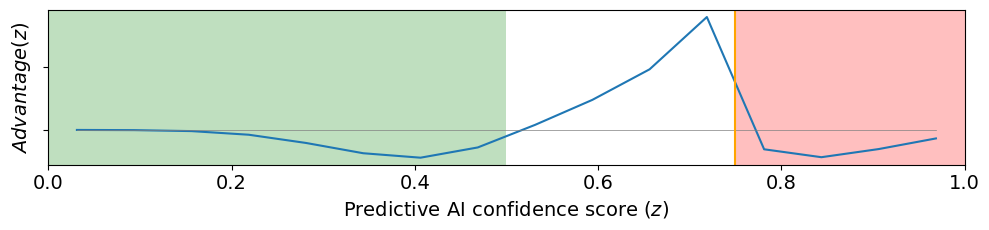

In [8]:
model = codoc.estimate_model(
    df_tune=df_tune,  # The tune dataset split.
    df_val=df_val,  # The validation dataset split.
    num_bins=selected_model_hp[
        "num_bins"
    ],  # $T$ from the main paper, number of bins.
    tau=selected_model_hp[
        "tau"
    ],  # Index for operating point for predictive AI: $\tau = \theta * T$.
    lam=selected_model_hp[
        "lam"
    ],  # $\lambda$ from the main paper, sens-spec trade off hyperparameter.
    pseudocounts=selected_model_hp[
        "pseudocounts"
    ],  # $\kappa$ from the main paper.
    smoothing_bandwidth=selected_model_hp[
        "smoothing_bandwidth"
    ],  # $\sigma$ from the main paper.
)

test_sens, test_spec = codoc.evaluate_codoc_model(
    df_test, model["operating_point"], model["thresholds"]
)
print("CoDoC sensitivity on test set:", test_sens)
print("CoDoC specificity on test set:", test_spec)
codoc.plot_advantage_z(model["phis"], model["params"]["tau"], model["a_z"])

print("Number of cases in test set is {}".format(len(df_test)))
print("Number of positive cases in test set is {}".format(df_test.y_true.sum()))

test_reader_sens, test_reader_spec = codoc.evaluate_baseline_reader(df_test)
print("Clinical workflow sensitivity on test set: {}".format(test_reader_sens))
print("Clinical workflow specificity on test set: {}".format(test_reader_spec))

test_ai_sens, test_ai_spec = codoc.evaluate_baseline_model(df_test)
print("Predictive AI sensitivity on test set: {}".format(test_ai_sens))
print("Predictive AI specificity on test set: {}".format(test_ai_spec))